In [137]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import (Conv2D, TimeDistributed, MaxPooling2D,
                                     MaxPooling3D, AveragePooling2D, Conv2DTranspose, UpSampling2D,
                                     Dense, Flatten, Reshape,Dropout)
from hopf_blurred import *
#from pulse2percept.stimuli import GratingStimulus
import scipy.io

import numpy as np
import os

In [138]:
import scipy.io
data5=scipy.io.loadmat('C:/Users/sinha/Desktop/sayan/epileptic_OCNN/sub5/model_dataset.mat')

EEG_data=data5["EEG_main"] # 4 channels EEG TRAINING Data
label=data5["label"]
print(EEG_data.shape,"raw_data", label.shape,"label")

(414, 64, 17) raw_data (414, 64, 2) label


In [139]:

np.random.seed(42)
#input_dim=60
#seq_len=35
import scipy.io

data_EEG = np.load(r'C:/Users/sinha/Desktop/sayan/epileptic_OCNN/sub5/img4_save.npy')
print(data_EEG.shape,"data_EEG")
data_label=label

print(data_EEG.shape,"raw_data",data_label.shape)
expanded_matrix = np.expand_dims(data_EEG, axis=-1)
print(expanded_matrix.shape,"raw_data1")
input_dim=50
seq_len=64

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(expanded_matrix, data_label, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(414, 64, 50, 50) data_EEG
(414, 64, 50, 50) raw_data (414, 64, 2)
(414, 64, 50, 50, 1) raw_data1
(331, 64, 50, 50, 1)
(83, 64, 50, 50, 1)
(331, 64, 2)
(83, 64, 2)


In [140]:
def ramp_accuracy(y_true, y_pred):
    pred_win_indx = tf.math.argmax(tf.math.reduce_mean(y_pred, 1), 1)
    grnd_win_indx = tf.math.argmax(tf.math.reduce_mean(y_true, 1), 1)
    return tf.math.reduce_mean(tf.cast(pred_win_indx==grnd_win_indx, 'float32'))

In [141]:
from tensorflow.keras import layers, Model

def feat_pool_dim_calc(inp_dim, k_dim, pool_dim=2):
  f_d = (inp_dim-k_dim) + 1
  p_d = (f_d-pool_dim)//pool_dim + 1
  return f_d, p_d

k1_d = 5
n_f1 = 5
f1_d, p1_d = feat_pool_dim_calc(input_dim, k1_d)

k2_d = 5
n_f2 = 5
#f2_d, p2_d = feat_pool_dim_calc(f1_d//2, k2_d)
f2_d, p2_d = feat_pool_dim_calc(f1_d, k2_d)

k3_d = 5
n_f3 = 10
#f3_d, p3_d = feat_pool_dim_calc(f2_d//2, k3_d)
f3_d, p3_d = feat_pool_dim_calc(f2_d, k3_d)

k4_d = 5
n_f4 = 10
f4_d, p4_d = feat_pool_dim_calc(f3_d, k4_d)

f1_d, f2_d, f3_d, f4_d



(46, 42, 38, 34)

In [142]:

from tensorflow.keras import layers, Model

class Autoencoder(Model):
   def __init__(self,units3,units4):
       super(Autoencoder, self).__init__()

       self.conv_r1 = tf.keras.layers.TimeDistributed(Conv2D(n_f1, (k1_d, k1_d), activation='relu'))
       self.conv_i1 = tf.keras.layers.TimeDistributed(Conv2D(n_f1, (k1_d, k1_d), activation='relu'))
       self.h1 = Hopf(f1_d, n_f1, seq_len, min_omega=0.1, max_omega=3.1)

       self.conv_r2 = tf.keras.layers.TimeDistributed(Conv2D(n_f2, (k2_d, k2_d), activation='relu'))
       self.conv_i2 = tf.keras.layers.TimeDistributed(Conv2D(n_f2, (k2_d, k2_d), activation='relu'))
       self.h2 = Hopf(f2_d, n_f2, seq_len, min_omega=0.1, max_omega=3.1)
       
       #self.avg_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling2D())

       #self.conv_r3 = tf.keras.layers.TimeDistributed(Conv2D(n_f3, (k3_d, k3_d), activation='relu'))
       #self.conv_i3 = tf.keras.layers.TimeDistributed(Conv2D(n_f3, (k3_d, k3_d), activation='relu'))
       #self.h3 = Hopf(f3_d, n_f3, seq_len, min_omega=0.1, max_omega=3.1)

       #self.conv_r4 = tf.keras.layers.TimeDistributed(Conv2D(n_f4, (k4_d, k4_d), activation='relu'))
       #self.conv_i4 = tf.keras.layers.TimeDistributed(Conv2D(n_f4, (k4_d, k4_d), activation='relu'))
       #self.h4 = Hopf(f4_d, n_f4, seq_len, min_omega=0.1, max_omega=3.1)


       self.flat = tf.keras.layers.TimeDistributed(Flatten())

       self.d1_r=tf.keras.layers.Dense(units3,activation='tanh')
       self.d1_i=tf.keras.layers.Dense(units3,activation='tanh')

       #self.d2_r=tf.keras.layers.Dense(units5,activation='tanh')
       #self.d2_i=tf.keras.layers.Dense(units5,activation='tanh')


       self.out_d=tf.keras.layers.Dense(units4,activation='linear')
       self.drop = Dropout(0.05)


   def call(self, inputs):
       cor1 = self.conv_r1(inputs)
       coi1 = self.conv_i1(inputs)
       z1_r, z1_i = self.h1(cor1, coi1)
       #z1_r = self.avg_pool(z1_r)
       #z1_i = self.avg_pool(z1_i)

       cor2 = self.conv_r2(z1_r)
       coi2 = self.conv_i2(z1_i)
       z2_r, z2_i = self.h2(cor2, coi2)
       
       #z2_r = self.avg_pool(z2_r)
       #z2_i = self.avg_pool(z2_i)

       #cor3 = self.conv_r3(z2_r)
       #coi3 = self.conv_i3(z2_i)
       #z3_r, z3_i = self.h3(cor3, coi3)

       #cor4 = self.conv_r4(z3_r)
       #coi4 = self.conv_i4(z3_i)
       #z4_r, z4_i = self.h4(cor4, coi4)

       out2_r=self.flat(z2_r)
       out2_i=self.flat(z2_i)

       out3_r = tf.keras.layers.TimeDistributed(self.d1_r)(out2_r)
       out3_i = tf.keras.layers.TimeDistributed(self.d1_i)(out2_i)

       #out4_r = tf.keras.layers.TimeDistributed(self.d2_r)(out3_r)
       #out4_i = tf.keras.layers.TimeDistributed(self.d2_i)(out3_i)

       out3=tf.concat([out3_r,out3_i],-1)
       out4=self.drop(out3)

       out_final = tf.keras.layers.TimeDistributed(self.out_d)(out4)

       return out_final

In [143]:
model = Autoencoder(10,2)
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer, 'mse', metrics=[ramp_accuracy] )

cp_callback = tf.keras.callbacks.ModelCheckpoint('C:/Users/sinha/Desktop/sayan/epileptic_OCNN/sub5/result',
                                                 save_best_only=True, monitor='loss', save_weights_only=True, verbose=1)

In [144]:
import time

# Start the timer
start_time = time.time()
history=model.fit(X_train, y_train, batch_size=1, epochs=30, shuffle=True, 
                  callbacks=[cp_callback], verbose=1, validation_data=(X_test,y_test))
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

Epoch 1/30
331/331 [==============================] - ETA: 0s - loss: 0.7348 - ramp_accuracy: 0.5408
Epoch 1: loss improved from inf to 0.73485, saving model to C:/Users/sinha/Desktop/sayan/epileptic_OCNN/sub5\result
331/331 [==============================] - 51s 147ms/step - loss: 0.7348 - ramp_accuracy: 0.5408 - val_loss: 0.3374 - val_ramp_accuracy: 0.7952
Epoch 2/30
331/331 [==============================] - ETA: 0s - loss: 0.4026 - ramp_accuracy: 0.6737
Epoch 2: loss improved from 0.73485 to 0.40256, saving model to C:/Users/sinha/Desktop/sayan/epileptic_OCNN/sub5\result
331/331 [==============================] - 48s 145ms/step - loss: 0.4026 - ramp_accuracy: 0.6737 - val_loss: 0.3280 - val_ramp_accuracy: 0.7952
Epoch 3/30
331/331 [==============================] - ETA: 0s - loss: 0.3847 - ramp_accuracy: 0.6647
Epoch 3: loss improved from 0.40256 to 0.38472, saving model to C:/Users/sinha/Desktop/sayan/epileptic_OCNN/sub5\result
331/331 [==============================] - 48s 145ms/

In [ ]:
model.summary()

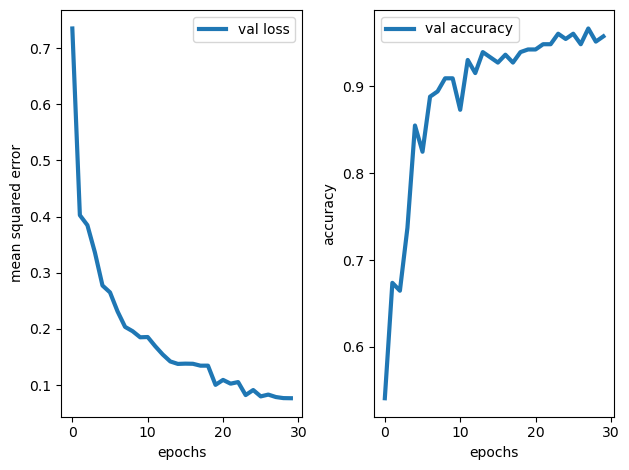

In [145]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(history.history['loss'], label="val loss", linewidth=3)
axs[1].plot(history.history['ramp_accuracy'], label="val accuracy",
            linewidth=3)
axs[0].set_xlabel("epochs")
axs[1].set_xlabel("epochs")
axs[0].set_ylabel("mean squared error")
axs[1].set_ylabel("accuracy")
axs[0].legend()
axs[1].legend()
plt.tight_layout()

In [146]:
# Start the timer
start_time = time.time()
out = model.predict(X_test, batch_size=1)
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

83/83 [==============================] - 1s 12ms/step


In [147]:
out.shape

(83, 64, 2)

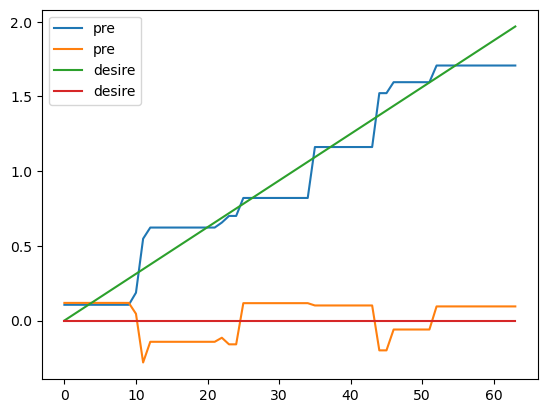

In [148]:
plt.plot(out[19], label='pre')
plt.plot(y_test[19], label ='desire')
plt.legend()
plt.show()

In [149]:
c=0
label_trn=y_test

for i in range(25):
    a=sum(out[i,:])
    indices = np.where(a == a.max())
    print(indices)
    b=sum(label_trn[i,:])
    indices1 = np.where(b == b.max())
    print(indices1)

    if indices==indices1:
       c=c+1

print(c)

(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([0], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([1], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([1], dtype=int64),)
(

AttributeError: 'History' object has no attribute 'History'

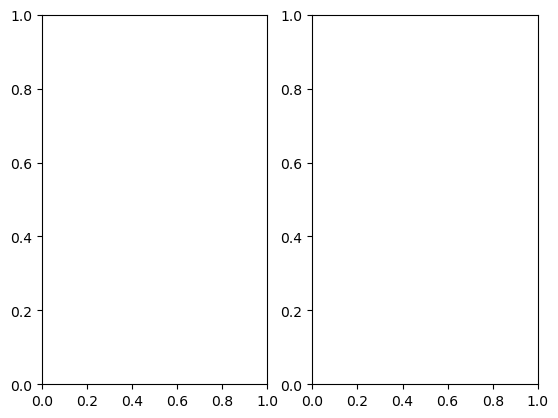

In [150]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(history.History['loss'], label="val loss", linewidth=3)
axs[1].plot(history.History['ramp_accuracy'], label="val accuracy",
            linewidth=3)
axs[0].set_xlabel("epochs")
axs[1].set_xlabel("epochs")
axs[0].set_ylabel("mean squared error")
axs[1].set_ylabel("accuracy")
axs[0].legend()
axs[1].legend()
plt.tight_layout()